In [35]:
import numpy as np
import pandas as pd
import yfinance as yf
import cvxpy as cp
import json
import re
import random
from datetime import datetime
import matplotlib.pyplot as plt

In [36]:
def get_data(tickers, dji_ticker, start_date, end_date):
    data = yf.download(tickers + [dji_ticker], start=start_date, end=end_date)['Close']
    returns = data.pct_change().dropna()
    return data, returns

# ✅ 무위험 수익률 가져오기 (10년물 국채 금리)
def get_risk_free_rate():
    try:
        treasury_data = yf.download("^TNX", period="1d")
        if not treasury_data.empty:
            return float(treasury_data["Close"].iloc[-1] / 100)  # 10년물 국채 금리 변환
    except Exception as e:
        print(f"⚠️ 국채 금리 데이터 가져오기 실패: {e}")
    return 0.02  # 기본값 설정 (예: 2%)

# ✅ CAPM을 이용해 개별 종목 기대 수익률 계산하는 함수
def calculate_capm_returns(returns, dji_ticker, rf):
    market_return = returns[dji_ticker].mean() * 252
    market_excess_return = market_return - rf

    betas = returns.cov().loc[tickers, dji_ticker] / returns[dji_ticker].var()
    expected_returns = rf + betas * market_excess_return
    cov_matrix = returns[tickers].cov() * 252  # 연율화된 공분산 행렬

    return expected_returns, cov_matrix

# ✅ 시장 가중치를 가져오는 함수
def get_market_weights(tickers):
    market_caps = {}  # 기업별 시가총액 저장

    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            market_caps[ticker] = stock.info.get("marketCap", None)
        except Exception as e:
            print(f"⚠️ {ticker} 시가총액 가져오기 실패: {e}")

    valid_caps = {k: v for k, v in market_caps.items() if v is not None}
    total_market_cap = sum(valid_caps.values())

    if total_market_cap == 0:
        print("⚠️ 유효한 시가총액 데이터가 없습니다.")
        return np.ones(len(tickers)) / len(tickers)  # 균등 가중치 반환

    return np.array([valid_caps.get(ticker, 0) / total_market_cap for ticker in tickers])

# ✅ JSON에서 투자자의 견해를 추출하는 함수
def extract_views_from_json(json_file, tickers, cov_matrix):
    with open(json_file, "r", encoding="utf-8") as f:
        data = json.load(f)

    views_text = data["views"]
    single_stock_pattern = r"\*\*(\w+)\*\* \(Expected Return: ([+-]?\d+(?:\.\d+)?)%\)"
    comparison_pattern = r"\*\*(\w+) vs. (\w+)\*\* \(Expected Outperformance: ([+-]?\d+(?:\.\d+)?)%\)"

    P_list, q_list, omega_list = [], [], []

    for match in re.findall(single_stock_pattern, views_text):
        stock, expected_return = match
        expected_return = float(expected_return) / 100  

        if stock in tickers:
            P_row = np.zeros(len(tickers))
            P_row[tickers.index(stock)] = 1
            P_list.append(P_row)
            q_list.append([expected_return])

            # ✅ 신뢰도를 랜덤하게 설정 (10% ~ 50%)
            confidence = np.random.uniform(0.1, 0.5)
            omega_list.append(cov_matrix.loc[stock, stock] * confidence)

    for match in re.findall(comparison_pattern, views_text):
        stock1, stock2, expected_return = match
        expected_return = float(expected_return) / 100  

        if stock1 in tickers and stock2 in tickers:
            P_row = np.zeros(len(tickers))
            P_row[tickers.index(stock1)] = 1
            P_row[tickers.index(stock2)] = -1
            P_list.append(P_row)
            q_list.append([expected_return])

            confidence = np.random.uniform(0.1, 0.5)
            omega_list.append((cov_matrix.loc[stock1, stock1] + cov_matrix.loc[stock2, stock2]) * confidence)

    P = np.array(P_list) if P_list else np.zeros((0, len(tickers)))
    q = np.array(q_list) if q_list else np.zeros((0, 1))
    Omega = np.diag(omega_list) if omega_list else np.zeros((0, 0))

    return P, q, Omega

# ✅ 블랙-리터만 모델 적용 (시장 가중치 포함)
def black_litterman_with_market_weights(expected_returns, cov_matrix, P, q, Omega, tau, market_weights, lambda_risk_aversion):
    Pi = lambda_risk_aversion * cov_matrix.to_numpy() @ market_weights.reshape(-1, 1)  # ✅ 시장 균형 기대수익률 계산

    M = np.linalg.inv(tau * cov_matrix.to_numpy())
    Omega_inv = np.linalg.inv(Omega) if Omega.shape[0] > 0 else np.zeros_like(Omega)

    if P.shape[0] > 0 and q.shape[0] > 0:
        BL_return = np.linalg.inv(M + P.T @ Omega_inv @ P) @ (M @ Pi + P.T @ Omega_inv @ q)
    else:
        BL_return = Pi

    return BL_return.flatten()

# ✅ 최적 포트폴리오 가중치 계산
def optimize_portfolio(BL_return, cov_matrix):
    w = cp.Variable(len(tickers))

    lambda_risk_aversion = 3.0
    objective = cp.Maximize(w @ BL_return - lambda_risk_aversion * cp.quad_form(w, cov_matrix.to_numpy()))

    constraints = [cp.sum(w) == 1, w >= 0]

    problem = cp.Problem(objective, constraints)
    problem.solve()

    w_cleaned = np.where(w.value < 1e-5, 0, w.value)
    return pd.Series(w_cleaned, index=tickers)

In [37]:
tickers = [
    "AAPL", "AMGN", "AMZN", "AXP", "BA", "CAT", "CRM", "CSCO", "CVX", "DIS", "DOW",
    "GS", "HD", "HON", "IBM", "INTC", "JNJ", "JPM", "KO", "MCD", "MMM", "MRK", "MSFT",
    "NKE", "PG", "TRV", "UNH", "V", "VZ", "WMT"
]
dji_ticker = "^DJI"
start_date = "2023-01-01"
end_date = "2024-12-31"
rf = get_risk_free_rate()
json_file_path = "./final_result.json"

data, returns = get_data(tickers, dji_ticker, start_date, end_date)
expected_returns, cov_matrix = calculate_capm_returns(returns, dji_ticker, rf)

market_weights = get_market_weights(tickers)  # ✅ 시장 가중치 추가
P, q, Omega = extract_views_from_json(json_file_path, tickers, cov_matrix)

print(P)
print(q)


tau = 0.05
lambda_risk_aversion = 3.0

BL_return = black_litterman_with_market_weights(expected_returns, cov_matrix, P, q, Omega, tau, market_weights, lambda_risk_aversion)

portfolio_weights = optimize_portfolio(BL_return, cov_matrix)

print("\n📌 최적 포트폴리오 가중치:")
print(portfolio_weights.sort_values(ascending=False))

import numpy as np

# ✅ 포트폴리오 가중치와 블랙 리터만 기대수익률이 존재하는지 확인
if 'portfolio_weights' in globals() and 'BL_return' in globals():
    # ✅ 가중치 벡터를 NumPy 배열로 변환 (필요 시 reshape)
    portfolio_weights = np.array(portfolio_weights).reshape(-1, 1)
    
    # ✅ 기대수익률 벡터를 NumPy 배열로 변환
    BL_return = np.array(BL_return).reshape(-1, 1)
    
    # ✅ 최종 기대수익률 계산
    final_expected_return = float(np.dot(portfolio_weights.T, BL_return))
    
    print("\n📌 최종 기대 수익률:")
    print(final_expected_return)
else:
    print("❌ Error: 'portfolio_weights' 또는 'BL_return'이 정의되지 않았습니다. 먼저 실행하세요.")


[*********************100%***********************]  1 of 1 completed
C:\Users\Owner\AppData\Local\Temp\ipykernel_8348\964951674.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(treasury_data["Close"].iloc[-1] / 100)  # 10년물 국채 금리 변환
[*********************100%***********************]  31 of 31 completed


[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]
[[-0.01 ]
 [ 0.03 ]
 [ 0.01 ]
 [ 0.061]]

📌 최적 포트폴리오 가중치:
KO      0.145923
MSFT    0.105806
AAPL    0.104213
WMT     0.076620
AMZN    0.073295
JNJ     0.063078
PG      0.061466
V       0.057454
CVX     0.043430
UNH     0.038049
MRK     0.036700
JPM     0.033616
IBM     0.026645
VZ      0.026311
DOW     0.024567
MCD     0.020444
DIS     0.019287
CSCO    0.013836
CRM     0.013449
BA      0.005783
HD      0.005120
HON     0.003119
CAT     0.001217
TRV     0.000572
AMGN    0.000000
AXP     0.000000
GS      0.000000
INTC    0.000000
MMM     0.000000
NKE     0.000000
dtype: float64

📌 최종 기대 수익률:
0.03410194401186312


C:\Users\Owner\AppData\Local\Temp\ipykernel_8348\3824846682.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  final_expected_return = float(np.dot(portfolio_weights.T, BL_return))


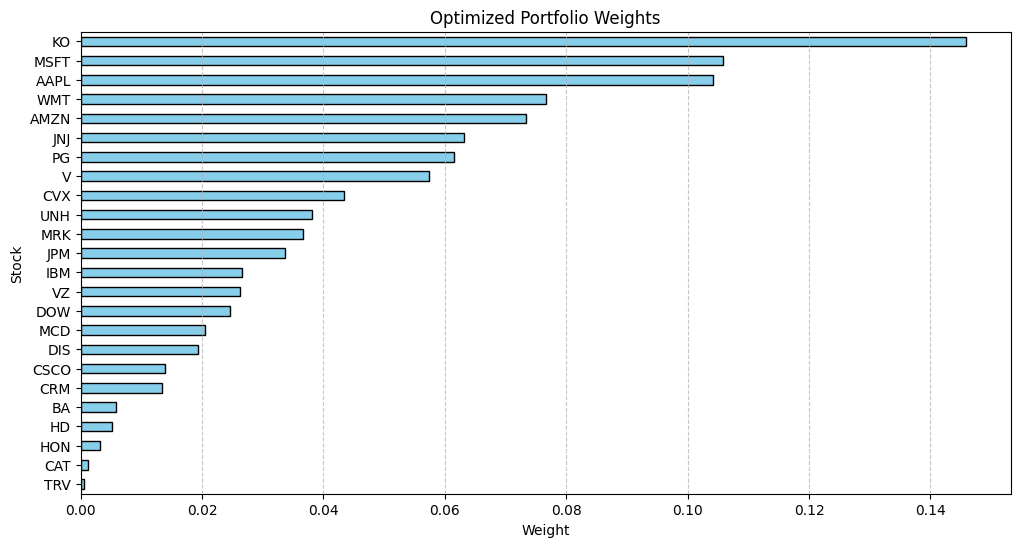

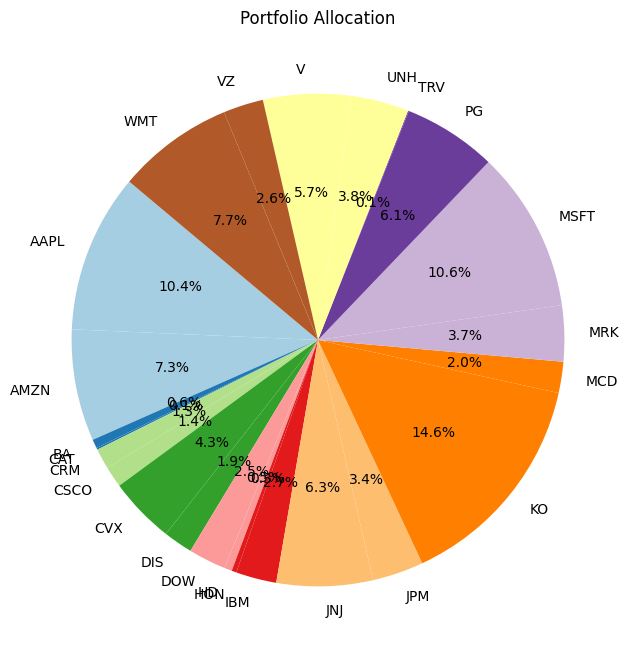

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# ✅ NumPy 배열을 Pandas Series로 변환 (tickers를 인덱스로 설정)
portfolio_weights = pd.Series(portfolio_weights.flatten(), index=tickers)

# ✅ 가중치가 0보다 큰 자산만 필터링
filtered_weights = portfolio_weights[portfolio_weights > 0]

# 🔹 **막대 그래프(bar chart)**
plt.figure(figsize=(12, 6))
filtered_weights.sort_values().plot(kind="barh", color="skyblue", edgecolor="black")
plt.xlabel("Weight")
plt.ylabel("Stock")
plt.title("Optimized Portfolio Weights")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

# 🔹 **원형 차트(pie chart)**
plt.figure(figsize=(8, 8))
filtered_weights.plot(kind="pie", autopct="%1.1f%%", startangle=140, cmap="Paired")
plt.ylabel("")  # y축 라벨 제거
plt.title("Portfolio Allocation")
plt.show()


In [40]:
import numpy as np
import pandas as pd

# ✅ 포트폴리오 및 다우존스 샤프 지수 비교 함수 (수정 버전)
def calculate_sharpe_ratio(returns, risk_free_rate):
    """
    Sharpe Ratio = (포트폴리오 평균 수익률 - 무위험 수익률) / 변동성
    """
    if returns.empty or returns.std() == 0:  # 변동성이 0이면 NaN 반환
        return None  # NaN 대신 None 반환

    # 연율화 초과 수익률 (무위험 수익률을 일별 수익률에서 먼저 차감)
    excess_return = (returns.mean() - risk_free_rate / 252) * 252
    volatility = returns.std() * np.sqrt(252)  # 연율화 변동성
    return excess_return / volatility

# ✅ returns 인덱스 변환 (DatetimeIndex 확인)
returns.index = pd.to_datetime(returns.index)

# ✅ 2023년, 2024년 수익률 필터링
returns_2023 = returns.loc["2023-01-01":"2023-12-31"] if not returns.empty else pd.DataFrame()
returns_2024 = returns.loc["2024-01-01":"2024-12-31"] if not returns.empty else pd.DataFrame()
returns_all = returns.loc["2023-01-01":"2024-12-31"] if not returns.empty else pd.DataFrame()  # 2023+2024 합친 데이터

# ✅ 블랙-리터만 포트폴리오 수익률 계산 (포트폴리오 가중치를 적용)
bl_portfolio_returns_2023 = returns_2023[tickers] @ portfolio_weights if not returns_2023.empty else pd.Series([0])
bl_portfolio_returns_2024 = returns_2024[tickers] @ portfolio_weights if not returns_2024.empty else pd.Series([0])
bl_portfolio_returns_all = returns_all[tickers] @ portfolio_weights if not returns_all.empty else pd.Series([0])  # 2023+2024 합친 것

# ✅ 다우존스 수익률
dji_returns_2023 = returns_2023[dji_ticker] if not returns_2023.empty else pd.Series([0])
dji_returns_2024 = returns_2024[dji_ticker] if not returns_2024.empty else pd.Series([0])
dji_returns_all = returns_all[dji_ticker] if not returns_all.empty else pd.Series([0])  # 2023+2024 합친 것

# ✅ 2023년 샤프 지수 계산
sharpe_bl_2023 = calculate_sharpe_ratio(bl_portfolio_returns_2023, rf)
sharpe_dji_2023 = calculate_sharpe_ratio(dji_returns_2023, rf)

# ✅ 2024년 샤프 지수 계산
sharpe_bl_2024 = calculate_sharpe_ratio(bl_portfolio_returns_2024, rf)
sharpe_dji_2024 = calculate_sharpe_ratio(dji_returns_2024, rf)

# ✅ 2023+2024 샤프 지수 계산 (새롭게 추가)
sharpe_bl_all = calculate_sharpe_ratio(bl_portfolio_returns_all, rf)
sharpe_dji_all = calculate_sharpe_ratio(dji_returns_all, rf)

# ✅ 결과 출력 (데이터가 없는 경우 예외 처리)
print(f"\n📌 2023년 샤프 지수")
print(f"Black-Litterman Portfolio: {sharpe_bl_2023:.4f}" if sharpe_bl_2023 is not None else "데이터 없음")
print(f"Dow Jones Index (^DJI): {sharpe_dji_2023:.4f}" if sharpe_dji_2023 is not None else "데이터 없음")

print(f"\n📌 2024년 샤프 지수")
print(f"Black-Litterman Portfolio: {sharpe_bl_2024:.4f}" if sharpe_bl_2024 is not None else "데이터 없음")
print(f"Dow Jones Index (^DJI): {sharpe_dji_2024:.4f}" if sharpe_dji_2024 is not None else "데이터 없음")

print(f"\n📌 2023-2024년 전체 샤프 지수 (합산)")
print(f"Black-Litterman Portfolio: {sharpe_bl_all:.4f}" if sharpe_bl_all is not None else "데이터 없음")
print(f"Dow Jones Index (^DJI): {sharpe_dji_all:.4f}" if sharpe_dji_all is not None else "데이터 없음")


📌 2023년 샤프 지수
Black-Litterman Portfolio: 1.4855
Dow Jones Index (^DJI): 0.8211

📌 2024년 샤프 지수
Black-Litterman Portfolio: 1.5981
Dow Jones Index (^DJI): 0.7534

📌 2023-2024년 전체 샤프 지수 (합산)
Black-Litterman Portfolio: 1.5345
Dow Jones Index (^DJI): 0.7879


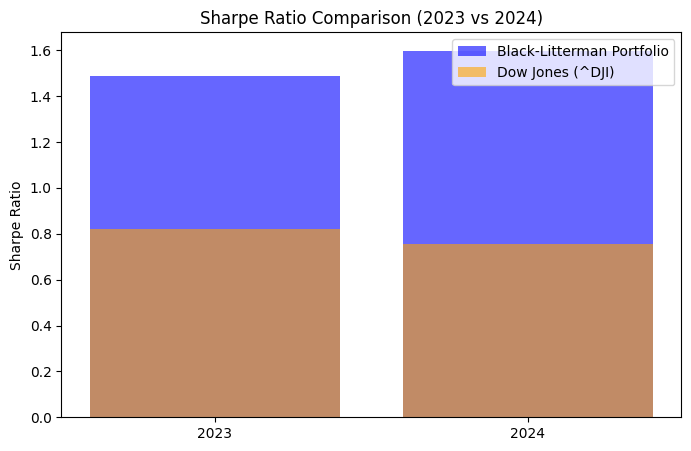

In [41]:
# ✅ 샤프 지수 시각화
years = ["2023", "2024"]
bl_sharpe = [sharpe_bl_2023, sharpe_bl_2024]
dji_sharpe = [sharpe_dji_2023, sharpe_dji_2024]

plt.figure(figsize=(8, 5))
plt.bar(years, bl_sharpe, color="blue", alpha=0.6, label="Black-Litterman Portfolio")
plt.bar(years, dji_sharpe, color="orange", alpha=0.6, label="Dow Jones (^DJI)")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio Comparison (2023 vs 2024)")
plt.legend()
plt.show()

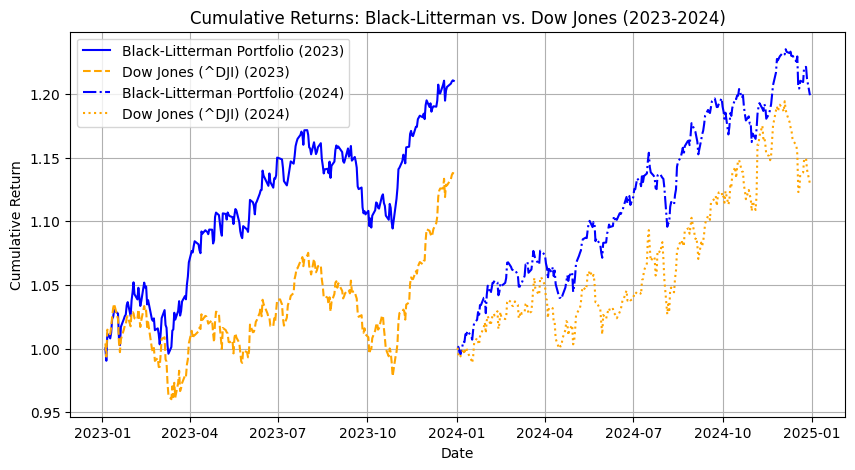

In [42]:
# ✅ 누적 수익률 계산
bl_cumulative_returns_2023 = (1 + bl_portfolio_returns_2023).cumprod()
bl_cumulative_returns_2024 = (1 + bl_portfolio_returns_2024).cumprod()

dji_cumulative_returns_2023 = (1 + dji_returns_2023).cumprod()
dji_cumulative_returns_2024 = (1 + dji_returns_2024).cumprod()

# ✅ 그래프 그리기
plt.figure(figsize=(10, 5))

plt.plot(bl_cumulative_returns_2023, label="Black-Litterman Portfolio (2023)", color="blue", linestyle="-")
plt.plot(dji_cumulative_returns_2023, label="Dow Jones (^DJI) (2023)", color="orange", linestyle="--")

plt.plot(bl_cumulative_returns_2024, label="Black-Litterman Portfolio (2024)", color="blue", linestyle="-.")
plt.plot(dji_cumulative_returns_2024, label="Dow Jones (^DJI) (2024)", color="orange", linestyle=":")

plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Cumulative Returns: Black-Litterman vs. Dow Jones (2023-2024)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# # ✅ 다양한 tau 값에 따른 Black-Litterman 기대 수익률 변화 분석
# tau_values = [0.025, 0.05, 0.1, 0.2]
# bl_return_means = []

# # ✅ 실제 Black-Litterman 모델을 적용하여 기대 수익률 계산
# for test_tau in tau_values:
#     BL_return = black_litterman(expected_returns, cov_matrix, P, q, Omega, test_tau)
#     bl_return_means.append(BL_return.mean())

# # ✅ 결과를 데이터프레임으로 정리
# tau_df = pd.DataFrame({"Tau Value": tau_values, "Mean Expected Return": bl_return_means})


# # ✅ 시각화: Tau 값에 따른 기대 수익률 변화
# plt.figure(figsize=(8, 5))
# plt.plot(tau_values, bl_return_means, marker="o", linestyle="-", color="b", label="Mean Expected Return")
# plt.xlabel("Tau Value")
# plt.ylabel("Mean Expected Return")
# plt.title("Black-Litterman Mean Expected Return vs. Tau")
# plt.grid(True)
# plt.legend()
# plt.show()


[*********************100%***********************]  1 of 1 completed
C:\Users\Owner\AppData\Local\Temp\ipykernel_8348\400037014.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  portfolio_volatility = float(portfolio_volatility)


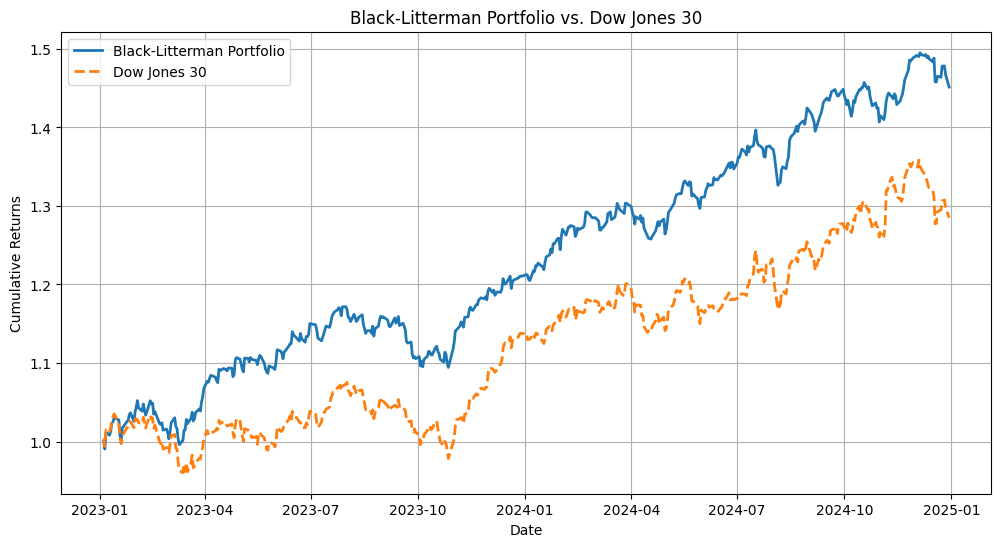

In [43]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ✅ 벤치마크 데이터 가져오기 (다우존스)
benchmark_tickers = ["^DJI"]  # 다우존스30
benchmark_data = yf.download(benchmark_tickers, start=start_date, end=end_date)['Close']

# ✅ 벤치마크 일별 수익률 계산
benchmark_returns = benchmark_data.pct_change().dropna()

# ✅ 벤치마크 기대 수익률 및 변동성 계산
benchmark_expected_returns = benchmark_returns.mean().to_numpy() * 252
benchmark_volatility = benchmark_returns.std().to_numpy() * np.sqrt(252)

# ✅ 포트폴리오 가중치 변환 (numpy 변환, 오류 방지)
portfolio_weights = np.array(portfolio_weights).reshape(-1, 1)  # numpy 배열 변환

# ✅ returns와 portfolio_weights의 종목 개수 맞추기
returns = returns[tickers]  # 불필요한 종목 제거
portfolio_weights = portfolio_weights[:returns.shape[1]]  # portfolio_weights 개수 조정

# ✅ 블랙 리터만 포트폴리오 변동성 계산
portfolio_volatility = np.sqrt(portfolio_weights.T @ cov_matrix.to_numpy() @ portfolio_weights)

# ✅ numpy array → float 변환 (오류 방지)
final_expected_return = float(final_expected_return)
portfolio_volatility = float(portfolio_volatility)

# ✅ 샤프 비율 계산
sharpe_dji = (benchmark_expected_returns[0] - rf) / benchmark_volatility[0]
sharpe_bl = (final_expected_return - rf) / portfolio_volatility

# ✅ 결과 출력
# ✅ 포트폴리오 누적 수익률 계산 (차원 오류 해결)
portfolio_cumulative_returns = (1 + returns.dot(portfolio_weights.flatten())).cumprod()

# ✅ 벤치마크 누적 수익률 계산
benchmark_cumulative_returns = (1 + benchmark_returns).cumprod()

# ✅ 시각화
plt.figure(figsize=(12, 6))
plt.plot(portfolio_cumulative_returns, label="Black-Litterman Portfolio", linestyle="-", linewidth=2)
plt.plot(benchmark_cumulative_returns["^DJI"], label="Dow Jones 30", linestyle="--", linewidth=2)
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title("Black-Litterman Portfolio vs. Dow Jones 30")
plt.legend()
plt.grid()
plt.show()
